In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tarundalal/top-15-anime-main-charcters")

print("Path to dataset files:", path)


100%|██████████| 519M/519M [00:05<00:00, 96.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tarundalal/top-15-anime-main-charcters/versions/1


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=c1a92c5d602e3f3937c34b251827b6967fcea261b4f97e8f70f89d1ebf43906a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.1 MB/s eta 0:00:00


In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torch.utils.data import DataLoader,random_split,TensorDataset, Subset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from collections import Counter
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report
from transformers import ViTForImageClassification

In [ ]:
project_name = 'course-project-anime-characters-classification'

In [ ]:
#importing data
data = '/root/.cache/kagglehub/datasets/tarundalal/top-15-anime-main-charcters/versions/1/anime_characters'
os.listdir(data)

['Sakata Gintoki',
 'Killua',
 'Gon',
 'Light Yagami',
 'Ichigo',
 'Luffy',
 'Elric Edward',
 'Naruto',
 'Natsu Dragneel',
 'Goku',
 'Zoro',
 'Sasuke',
 'Vegeta',
 'Lelouch Lamperouge',
 'Eren Yeager']

# Exploring the data

In [ ]:
data = '/root/.cache/kagglehub/datasets/tarundalal/top-15-anime-main-charcters/versions/1/anime_characters'
characters = os.listdir(data)

In [ ]:
print(characters)

['Sakata Gintoki', 'Killua', 'Gon', 'Light Yagami', 'Ichigo', 'Luffy', 'Elric Edward', 'Naruto', 'Natsu Dragneel', 'Goku', 'Zoro', 'Sasuke', 'Vegeta', 'Lelouch Lamperouge', 'Eren Yeager']


In [ ]:
print("Total characters classes are: {}".format(len(characters)))

Total characters classes are: 15


In [ ]:
nums = {}
for character in characters:
    nums[character] = len(os.listdir(data + '/' + character))

    # converting the nums dictionary to pandas dataframe passing index as character name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Sakata Gintoki,94
Killua,100
Gon,90
Light Yagami,99
Ichigo,100
Luffy,144
Elric Edward,91
Naruto,62
Natsu Dragneel,88
Goku,100


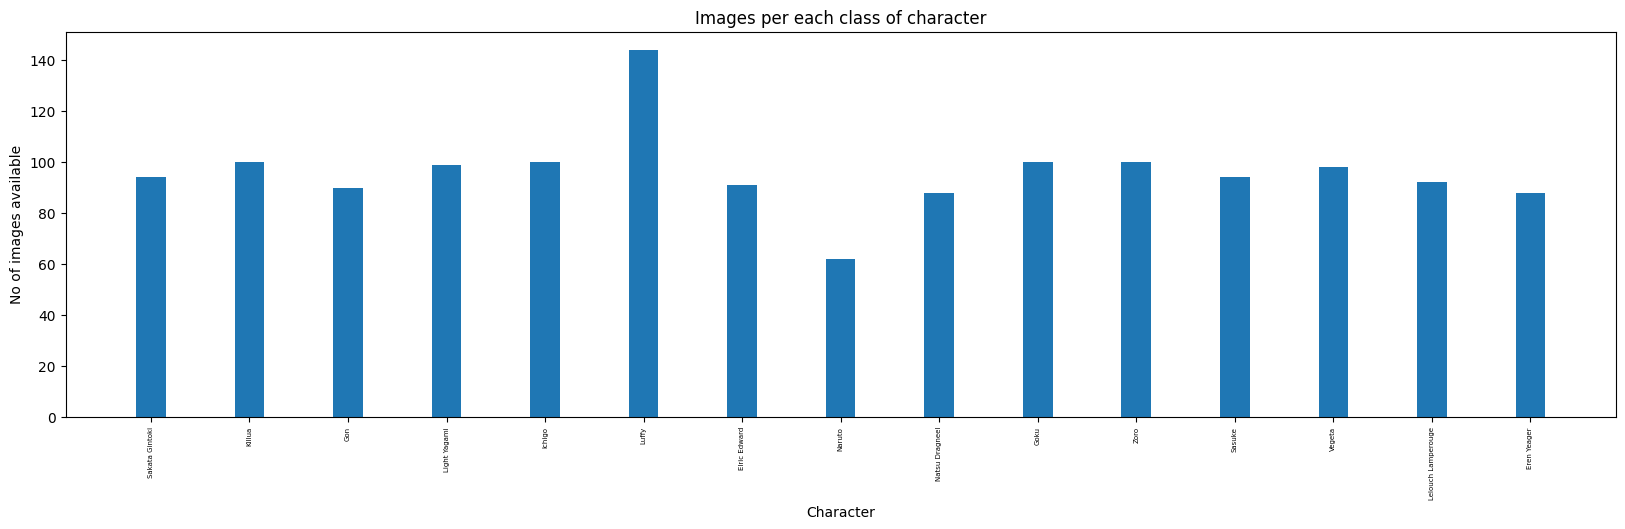

In [ ]:
# plotting number of images available for each character
index = [n for n in range(15)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Character', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, characters, fontsize=5, rotation=90)
plt.title('Images per each class of character')
plt.show()

## Here we can see, that we have unbalance number of images so we need to balance all images for the each classes

# Prepare data before applying machine learning algorithms

In [ ]:
## Define a sequence of transformations to preprocess the anime images
transform=transforms.Compose([
        transforms.Resize(256),             # resize shortest side to 256 pixels
        transforms.CenterCrop(256),         # crop longest side to 256 pixels at center
        transforms.ToTensor(),              # Convert the image to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406],         ## Normalize the image using mean values for RGB channels
                             [0.229, 0.224, 0.225])         ## and standard deviation values for RGB channels
])

In [ ]:
# Load the dataset with specified directory and transformations
dataset = datasets.ImageFolder(root='/root/.cache/kagglehub/datasets/tarundalal/top-15-anime-main-charcters/versions/1/anime_characters',
                               transform=transform)

# Get class indices and count images per class
class_indices = dataset.targets
class_counts = Counter(class_indices)

# Set target size for each class and create a list for balanced dataset indices
target_size = 100
indices = []

# Balance dataset by selecting 'target_size' images per class
for class_id, count in class_counts.items():
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_id]
    selected_indices = (class_indices[:target_size] if count > target_size
                        else class_indices * (target_size // count) + class_indices[:(target_size % count)])
    indices.extend(selected_indices)

# Create a balanced dataset with equal images per class
balanced_dataset = Subset(dataset, indices)


In [ ]:
balanced_dataset

In [ ]:
from collections import Counter

# Get target labels and count images per class in the balanced dataset
class_indices_balanced = [dataset.targets[i] for i in balanced_dataset.indices]
class_counts_balanced = Counter(class_indices_balanced)

# Map class names to their respective counts
class_names = dataset.classes
class_counts_dict = {class_names[i]: class_counts_balanced[i] for i in sorted(class_counts_balanced.keys())}

# Print class counts
print(class_counts_dict)


{'Elric Edward': 100, 'Eren Yeager': 100, 'Goku': 100, 'Gon': 100, 'Ichigo': 100, 'Killua': 100, 'Lelouch Lamperouge': 100, 'Light Yagami': 100, 'Luffy': 100, 'Naruto': 100, 'Natsu Dragneel': 100, 'Sakata Gintoki': 100, 'Sasuke': 100, 'Vegeta': 100, 'Zoro': 100}


In [ ]:
# Retrieve the 300th image and label from the balanced dataset
image, label = balanced_dataset[300]

# Print image details: shape, label, class name, and pixel values
print("Image shape:", image.shape)
print("Image Label:", label)
print("Image Class:", dataset.classes[label])
print(image)


Image shape: torch.Size([3, 256, 256])
Image Label: 3
Image Class: Gon
tensor([[[-2.0837, -1.8953, -1.6555,  ..., -1.9809, -1.9809, -1.9980],
         [-2.1008, -2.1008, -1.9809,  ..., -1.9980, -2.0152, -2.0152],
         [-2.1008, -2.1008, -2.1179,  ..., -1.9980, -2.0152, -2.0323],
         ...,
         [ 1.0673,  1.0844,  1.0844,  ..., -1.3302, -0.9534, -1.4158],
         [ 1.0502,  1.0502,  1.0673,  ..., -1.3130, -0.8678, -1.0562],
         [ 0.9988,  1.0159,  1.0159,  ..., -1.2959, -0.9020, -0.8335]],

        [[-1.8431, -1.5805, -1.1604,  ..., -1.8782, -1.8782, -1.8606],
         [-1.9482, -1.8782, -1.6331,  ..., -1.8957, -1.8957, -1.8782],
         [-2.0007, -1.9657, -1.9132,  ..., -1.8957, -1.8957, -1.8957],
         ...,
         [ 1.6583,  1.6758,  1.6583,  ..., -0.4076,  0.1176, -0.6001],
         [ 1.6408,  1.6583,  1.6232,  ..., -0.3550,  0.2927,  0.0126],
         [ 1.6232,  1.6232,  1.6057,  ..., -0.2500,  0.3277,  0.3102]],

        [[-1.7696, -1.6127, -1.4210,  ..., -1

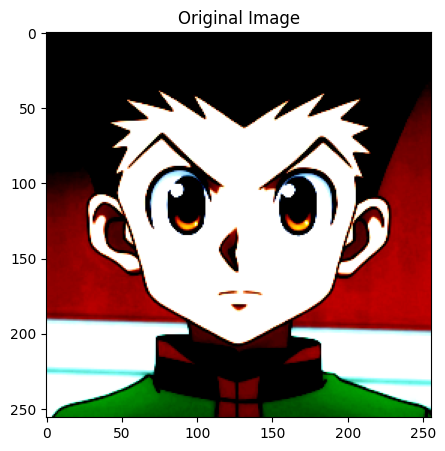

In [ ]:
#Retrieve the 300th image and its corresponding label from the balanced dataset
image, label = balanced_dataset[300]
# Display the image using matplotlib
plt.figure(figsize=(15, 5))# Set the figure size

plt.imshow(image.permute(1, 2, 0))  # Reorder the tensor dimensions to match (Height, Width, Channels)
plt.title("Original Image") # Add a title to the plot
plt.show() # Display the plot

## We normalized and applied some techniques to resize image and make size equal to each other

# Divide dataset on train, validation and test data

In [ ]:
# Calculate total samples and split into 80% training and 20% testing
n_data = len(balanced_dataset)
n_train = int(0.8 * n_data)
n_test = n_data - n_train


In [ ]:
# Split the balanced dataset into training and testing subsets
train_dataset, test_dataset = torch.utils.data.random_split(balanced_dataset, [n_train, n_test])


In [ ]:
print("Number of training images: ",len(train_dataset))
print("Number of testing images: ",len(test_dataset))

Number of training images:  1200
Number of testing images:  300


In [ ]:
# Define batch size and create DataLoaders for training and testing
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


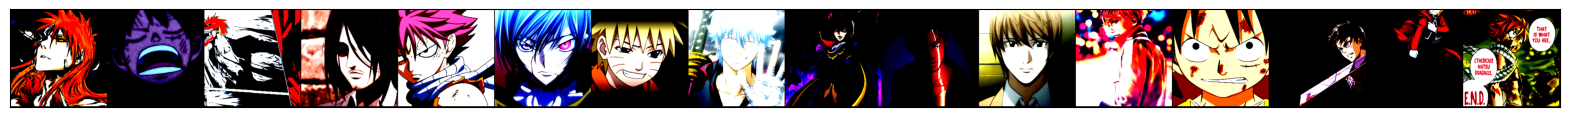

In [ ]:
# Display a batch of training images
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))  # Create a figure
    ax.set_xticks([]); ax.set_yticks([])  # Remove axis ticks
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))  # Show image grid
    break  # Display only the first batch


## Here is the final version for train and test data

#Building the model and evaluate the results

## Create device to move all models on GPU

In [ ]:

# Set device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Import necessary libraries for data processing, machine learning, and evaluation
import numpy as np
from sklearn.decomposition import PCA  # For dimensionality reduction
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble classifiers
from sklearn.linear_model import LogisticRegression  # Logistic Regression classifier
from sklearn.metrics import accuracy_score  # For evaluating model accuracy


# Define a function to flatten image data from a DataLoader
def flatten_loader(loader):
    """
    Flattens image data from a DataLoader into a 2D array (features) and extracts labels.

    Args:
        loader: A PyTorch DataLoader containing image data and labels.

    Returns:
        features: A NumPy array of flattened image data (samples x features).
        labels: A NumPy array of corresponding labels.
    """
    features, labels = [], []  # Initialize empty lists to store features and labels
    for batch in loader:  # Iterate through each batch in the DataLoader
        images, targets = batch  # Unpack images and labels from the batch
        features.extend(images.numpy().reshape(len(images), -1))  # Flatten images and add to features
        labels.extend(targets.numpy())  # Add labels to the labels list
    return np.array(features), np.array(labels)  # Return features and labels as NumPy arrays


# Apply the flatten_loader function to the training and testing DataLoaders
train_flat, train_labels = flatten_loader(train_loader)  # Flatten training data
test_flat, test_labels = flatten_loader(test_loader)  # Flatten testing data

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Print the shape of training and testing labels to show the number of samples
print("Train Labels Shape:", train_labels.shape)
print("Test Labels Shape:", test_labels.shape)

Train Labels Shape: (1200,)
Test Labels Shape: (300,)


In [ ]:
# Initialize PCA with 100 components to reduce data dimensionality
pca = PCA(n_components=100)

# Fit PCA on the training data and transform it
train_pca = pca.fit_transform(train_flat)

# Transform the testing data using the fitted PCA model
test_pca = pca.transform(test_flat)

# Print the shapes of the reduced training and testing data
print("Reduced Train Feature Shape:", train_pca.shape)
print("Reduced Test Feature Shape:", test_pca.shape)


Reduced Train Feature Shape: (1200, 100)
Reduced Test Feature Shape: (300, 100)


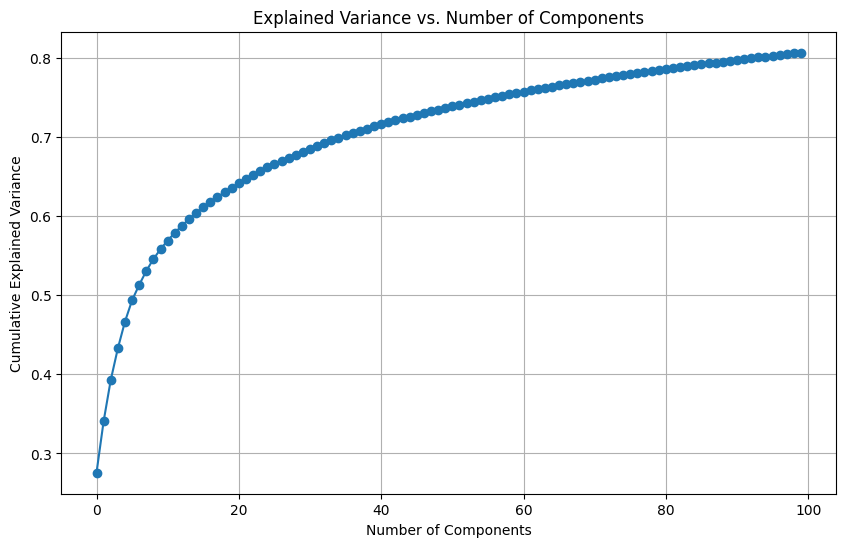

In [ ]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Create a figure with specified size
plt.figure(figsize=(10, 6))

# Plot cumulative explained variance vs. number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

# Set labels and title for the plot
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')

# Add grid and show the plot
plt.grid()
plt.show()


Most of the variance (80%) can be retained by using fewer than 100 components.

In [ ]:
# Import necessary libraries for Logistic Regression, data scaling, and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Create and fit a StandardScaler for feature scaling
scaler = StandardScaler()
train_pca_scaled = scaler.fit_transform(train_pca)  # Scale training data
test_pca_scaled = scaler.transform(test_pca)  # Scale testing data

# Create and train a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='saga', class_weight='balanced')
lr_model.fit(train_pca_scaled, train_labels)

# Make predictions and evaluate the model
lr_predictions = lr_model.predict(test_pca_scaled)
print("Logistic Regression Accuracy:", accuracy_score(test_labels, lr_predictions))
print("Classification Report:\n", classification_report(test_labels, lr_predictions))


Logistic Regression Accuracy: 0.37
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.47      0.44        19
           1       0.16      0.25      0.19        12
           2       0.14      0.04      0.07        23
           3       0.67      0.64      0.65        22
           4       0.25      0.24      0.24        21
           5       0.48      0.50      0.49        24
           6       0.38      0.36      0.37        25
           7       0.18      0.17      0.17        18
           8       0.42      0.59      0.49        17
           9       0.48      0.52      0.50        21
          10       0.45      0.41      0.43        22
          11       0.38      0.33      0.36        24
          12       0.20      0.20      0.20        15
          13       0.30      0.41      0.35        17
          14       0.37      0.35      0.36        20

    accuracy                           0.37       300
   macro avg       0.

In [ ]:
# Import the SVC model and evaluation metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize and configure the SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

# Train the SVM model on the training data
svm_model.fit(train_pca, train_labels)

# Predict on the test data
svm_predictions = svm_model.predict(test_pca)

# Evaluate the model's performance
print("SVM Test Accuracy:", accuracy_score(test_labels, svm_predictions))
print("SVM Classification Report:\n", classification_report(test_labels, svm_predictions))


SVM Test Accuracy: 0.3933333333333333
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.58      0.38        19
           1       0.12      0.25      0.17        12
           2       0.20      0.04      0.07        23
           3       0.72      0.59      0.65        22
           4       0.31      0.19      0.24        21
           5       0.68      0.62      0.65        24
           6       0.58      0.28      0.38        25
           7       0.11      0.17      0.13        18
           8       0.69      0.65      0.67        17
           9       0.59      0.62      0.60        21
          10       0.61      0.50      0.55        22
          11       0.38      0.58      0.46        24
          12       0.38      0.33      0.36        15
          13       0.14      0.18      0.16        17
          14       0.31      0.20      0.24        20

    accuracy                           0.39       300
   macro avg  

In [ ]:
# Import Random Forest Classifier and evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

# Train the Random Forest model on the training data
rf_model.fit(train_pca, train_labels)

# Predict on the test data
rf_predictions = rf_model.predict(test_pca)

# Evaluate the model's performance
print("Random Forest Test Accuracy:", accuracy_score(test_labels, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(test_labels, rf_predictions))


Random Forest Test Accuracy: 0.49666666666666665
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.53      0.38        19
           1       0.31      0.75      0.44        12
           2       0.43      0.13      0.20        23
           3       0.75      0.68      0.71        22
           4       0.50      0.24      0.32        21
           5       0.50      0.62      0.56        24
           6       0.81      0.52      0.63        25
           7       0.41      0.39      0.40        18
           8       0.53      0.59      0.56        17
           9       0.86      0.86      0.86        21
          10       0.50      0.55      0.52        22
          11       0.39      0.50      0.44        24
          12       0.54      0.47      0.50        15
          13       0.43      0.35      0.39        17
          14       0.44      0.35      0.39        20

    accuracy                           0.50    

In [ ]:
# Import Gradient Boosting Classifier and evaluation metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Gradient Boosting model with specified parameters
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the Gradient Boosting model on the training data
gb_model.fit(train_pca, train_labels)

# Predict on the test data
gb_predictions = gb_model.predict(test_pca)

# Evaluate the model's performance
print("Gradient Boosting Test Accuracy:", accuracy_score(test_labels, gb_predictions))
print("Gradient Boosting Classification Report:\n", classification_report(test_labels, gb_predictions))



Gradient Boosting Test Accuracy: 0.4166666666666667
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.53      0.41        19
           1       0.23      0.58      0.33        12
           2       0.25      0.13      0.17        23
           3       0.61      0.50      0.55        22
           4       0.25      0.24      0.24        21
           5       0.52      0.54      0.53        24
           6       0.52      0.52      0.52        25
           7       0.31      0.44      0.36        18
           8       0.64      0.53      0.58        17
           9       0.76      0.62      0.68        21
          10       0.63      0.55      0.59        22
          11       0.39      0.29      0.33        24
          12       0.22      0.27      0.24        15
          13       0.27      0.24      0.25        17
          14       0.46      0.30      0.36        20

    accuracy                           0

In [ ]:
# Importing pandas to create a DataFrame for storing model evaluation results
import pandas as pd

# Create a dictionary to store the model names and their corresponding test accuracies
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting'],
    'Test Accuracy': [
        accuracy_score(test_labels, lr_predictions),  # Accuracy for Logistic Regression
        accuracy_score(test_labels, svm_predictions), # Accuracy for SVM
        accuracy_score(test_labels, rf_predictions),  # Accuracy for Random Forest
        accuracy_score(test_labels, gb_predictions)   # Accuracy for Gradient Boosting
    ]
}

# Convert the dictionary into a pandas DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the DataFrame to display the results
print(results_df)


                 Model  Test Accuracy
0  Logistic Regression       0.370000
1                  SVM       0.393333
2        Random Forest       0.496667
3    Gradient Boosting       0.416667


In [ ]:
# Import necessary libraries for GridSearchCV and Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for tuning Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],          # Regularization strengths
    'solver': ['lbfgs', 'liblinear'],     # Solvers to test
    'penalty': ['l2']                     # L2 regularization
}

# Initialize GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=500, random_state=42),  # Logistic Regression model
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit the grid search on the training data
grid_search_lr.fit(train_pca, train_labels)

# Print the best hyperparameters and validation accuracy
print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best Validation Accuracy:", grid_search_lr.best_score_)

# Get the best model and make predictions on the test set
best_lr_model = grid_search_lr.best_estimator_
lr_predictions_best = best_lr_model.predict(test_pca)

# Print test accuracy of the best model
print("Logistic Regression Test Accuracy with Best Parameters:", accuracy_score(test_labels, lr_predictions_best))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Validation Accuracy: 0.3475
Logistic Regression Test Accuracy with Best Parameters: 0.3466666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Import the necessary libraries for SVC and GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning the SVM model
param_grid_svm = {
    'C': [0.1, 1, 10, 100],          # Regularization strength values
    'kernel': ['linear', 'rbf', 'poly'],  # Types of kernels to test
    'gamma': ['scale', 'auto']       # Kernel coefficients for non-linear kernels
}

# Initialize GridSearchCV with the Support Vector Classifier
grid_search_svm = GridSearchCV(
    SVC(random_state=42),            # SVC model with fixed random state
    param_grid_svm,                  # The parameter grid
    cv=5,                            # 5-fold cross-validation
    scoring='accuracy',              # Evaluation metric: accuracy
    verbose=2,                       # Detailed logs during the search
    n_jobs=-1                        # Use all processors for cross-validation
)

# Fit the grid search to the training data
grid_search_svm.fit(train_pca, train_labels)

# Print the best hyperparameters and best validation accuracy
print("Best SVM Parameters:", grid_search_svm.best_params_)
print("Best Validation Accuracy:", grid_search_svm.best_score_)

# Retrieve the best model from the grid search
best_svm_model = grid_search_svm.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Validation Accuracy: 0.42750000000000005


In [ ]:
# Import necessary libraries for Random Forest Classifier and GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning the Random Forest model
param_grid_rf = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [10, 20, None],              # Maximum depth of the trees (None for no limit)
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required at a leaf node
    'bootstrap': [True, False]                # Whether to use bootstrap samples when building trees
}

# Initialize GridSearchCV with RandomForestClassifier and the parameter grid
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),  # Random Forest model with fixed random state
    param_grid_rf,                            # Parameter grid for hyperparameter tuning
    cv=5,                                     # 5-fold cross-validation
    scoring='accuracy',                       # Evaluation metric: accuracy
    verbose=2,                                # Detailed logs during grid search
    n_jobs=-1                                 # Use all processors for cross-validation
)

# Fit the grid search to the training data
grid_search_rf.fit(train_pca, train_labels)

# Print the best hyperparameters and best cross-validation score
print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Validation Accuracy:", grid_search_rf.best_score_)

# Retrieve the best model from the grid search
best_rf_model = grid_search_rf.best_estimator_


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Validation Accuracy: 0.44416666666666665


In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# param_grid_gb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }


# grid_search_gb = GridSearchCV(
#     GradientBoostingClassifier(random_state=42),
#     param_grid_gb,
#     cv=5,
#     scoring='accuracy',
#     verbose=2,
#     n_jobs=-1
# )
# grid_search_gb.fit(train_pca, train_labels)

# # Best parameters and evaluation
# print("Best Gradient Boosting Parameters:", grid_search_gb.best_params_)
# print("Best Validation Accuracy:", grid_search_gb.best_score_)
# best_gb_model = grid_search_gb.best_estimator_


In [ ]:
# Importing the XGBoost classifier and RandomizedSearchCV for hyperparameter tuning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for RandomizedSearchCV to tune the XGBoost model
param_dist_xgb = {
    'n_estimators': [50, 100, 200],               # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],            # Learning rate for boosting
    'max_depth': [3, 5, 7],                        # Maximum depth of the trees
    'subsample': [0.8, 1.0],                       # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 1.0],                # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2],                       # Minimum loss reduction for further partitioning
    'reg_alpha': [0, 0.1, 0.2],                    # L1 regularization strength
    'reg_lambda': [1, 1.5, 2]                      # L2 regularization strength
}

# Initialize RandomizedSearchCV with XGBoost classifier and the defined parameter distribution
random_search_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),  # XGBoost model
    param_distributions=param_dist_xgb,  # Parameter distribution for randomized search
    n_iter=20,                           # Number of iterations for search
    cv=5,                                # 5-fold cross-validation
    scoring='accuracy',                  # Evaluation metric: accuracy
    verbose=2,                            # Detailed logs during the search
    random_state=42,                     # Ensures reproducibility
    n_jobs=-1                             # Use all processors for parallel cross-validation
)

# Fit the randomized search on the training data
random_search_xgb.fit(train_pca, train_labels)

# Print the best hyperparameters and the best cross-validation score
print("Best XGBoost Parameters:", random_search_xgb.best_params_)
print("Best Validation Accuracy:", random_search_xgb.best_score_)

# Retrieve the best model from the random search
best_xgb_model = random_search_xgb.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:46:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.2, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best Validation Accuracy: 0.3916666666666667


In [ ]:
# Import necessary libraries for evaluation and result visualization
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Define a dictionary to store the best models from the grid/random search
models = {
    'Logistic Regression': best_lr_model,    # Best Logistic Regression model
    'SVM': best_svm_model,                  # Best Support Vector Machine model
    'Random Forest': best_rf_model,          # Best Random Forest model
    # 'Gradient Boosting': best_gb_model,   # Uncomment if Gradient Boosting is used
    'XGBoost': best_xgb_model               # Best XGBoost model
}

# Initialize an empty list to store results for each model
results = []

# Loop through each model in the models dictionary
for name, model in models.items():
    # Make predictions on the test set
    predictions = model.predict(test_pca)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(test_labels, predictions)

    # Print the model's test accuracy
    print(f"{name} Test Accuracy: {accuracy:.4f}")

    # Print the classification report for the model
    print(f"Classification Report for {name}:\n", classification_report(test_labels, predictions))

    # Append the model name and accuracy to the results list
    results.append({'Model': name, 'Test Accuracy': accuracy})

# Convert the results list into a pandas DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the DataFrame containing the test accuracies of all models
print(results_df)


Logistic Regression Test Accuracy: 0.3467
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.33      0.47      0.39        19
           1       0.10      0.17      0.12        12
           2       0.11      0.04      0.06        23
           3       0.64      0.64      0.64        22
           4       0.24      0.19      0.21        21
           5       0.46      0.46      0.46        24
           6       0.30      0.28      0.29        25
           7       0.20      0.17      0.18        18
           8       0.42      0.59      0.49        17
           9       0.44      0.52      0.48        21
          10       0.43      0.41      0.42        22
          11       0.38      0.33      0.36        24
          12       0.23      0.20      0.21        15
          13       0.24      0.29      0.26        17
          14       0.39      0.35      0.37        20

    accuracy                           0.35 

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create  a voting classifier with soft voting, but set probability=True for SVC
voting_clf = VotingClassifier(
    estimators=[
        ('Logistic Regression', best_lr_model),
        ('SVM', SVC(probability=True, random_state=42)),  # Enable probability for SVC
        ('Random Forest', best_rf_model),
        ('XGBoost', best_xgb_model)
    ],
    voting='soft'
)

# Train the voting classifier
voting_clf.fit(train_pca, train_labels)

# Predict on the test set
y_pred = voting_clf.predict(test_pca)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Voting Classifier Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:47:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Accuracy: 0.48


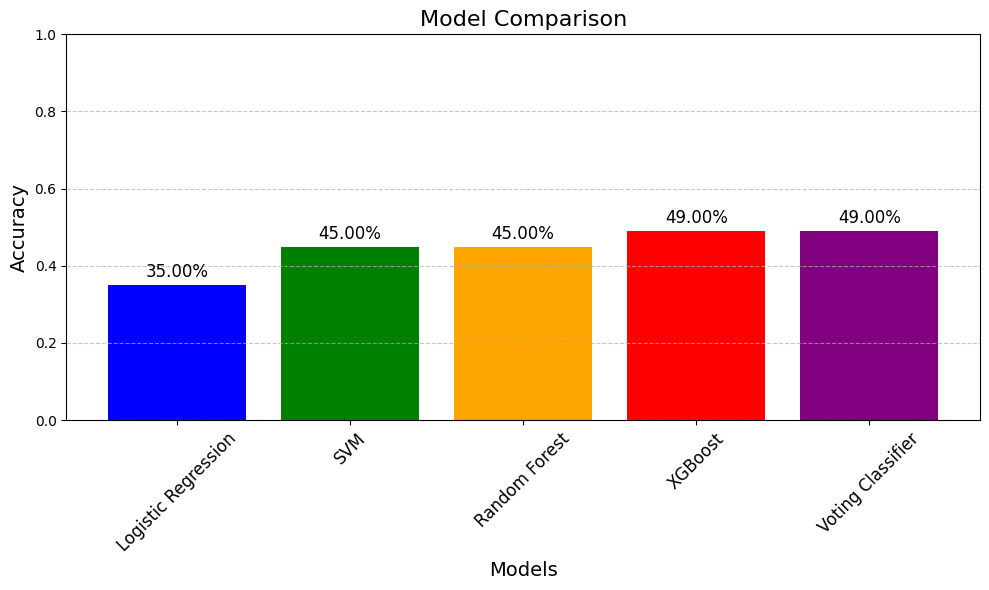

In [ ]:
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt
import pandas as pd

# Defining the model comparison results
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost','Voting Classifier'],
    'Accuracy': [0.35, 0.45, 0.45, 0.49, 0.47]  # Test accuracies of different models
}

# Converting the results dictionary into a pandas DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Creating a bar chart to compare the accuracy of different models
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'green', 'orange', 'red', 'purple'])

# Adding titles and labels to the plot
plt.title('Model Comparison', fontsize=16)  # Title of the plot
plt.xlabel('Models', fontsize=14)           # Label for the x-axis
plt.ylabel('Accuracy', fontsize=14)         # Label for the y-axis

# Setting the y-axis limits and adding grid lines
plt.ylim(0, 1)  # Y-axis limits from 0 to 1 (accuracy scale)
plt.xticks(rotation=45, fontsize=12)  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding horizontal grid lines for clarity

# Annotating the bar chart with the accuracy values
for i, acc in enumerate(results_df['Accuracy']):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12)  # Display percentage above each bar

# Adjusting the layout to avoid overlap and ensure the labels fit
plt.tight_layout()

# Displaying the plot
plt.show()


## Training Density NN

In [ ]:
input_size = 3 * 256 * 256
hidden_size = 516
output_size = 15

In [ ]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Initialize model and move it to the appropriate device
model = SimpleNN(input_size, hidden_size, output_size).to(device)

## Trainging with Stohastic gradient descent optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# Initialize empty list to store losses
losses = []
num_epochs = 5

# Training loop for specified epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Iterate through batches in the training loader
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero gradients, forward pass, loss, backprop, optimizer step
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute and record average loss
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)

    # Print epoch loss
    print(f"Epoch [{epoch+1}/5], Loss: {epoch_loss:.4f}")

  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], Loss: 2.7001


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/5], Loss: 1.3891


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/5], Loss: 0.7923


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/5], Loss: 0.3975


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/5], Loss: 0.2503


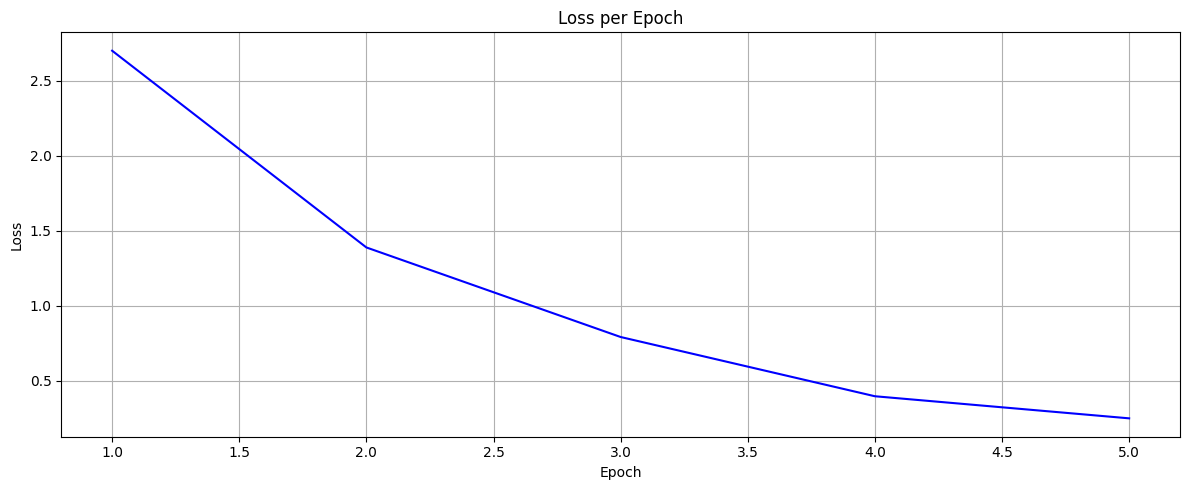

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure size for the plot
plt.figure(figsize=(12, 5))

# Plot the loss values over epochs
plt.plot(range(1, num_epochs + 1), losses, label='Loss', color='blue')

# Label the x-axis and y-axis
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Set the title of the plot
plt.title('Loss per Epoch')

# Enable grid lines for better readability
plt.grid(True)

# Adjust the layout for proper display
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_predictions = []

# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
model.eval()

# Disable gradient calculation during evaluation to save memory
with torch.no_grad():
    # Iterate over the training data in batches
    for images, labels in tqdm(train_loader):  # Progress bar using tqdm
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Perform a forward pass through the model to get the predictions
        outputs = model(images)

        # Get the predicted class (index of the highest output probability)
        _, predicted = torch.max(outputs, 1)

        # Add the true labels and predicted labels to the respective lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_predictions)

# Print the classification report
print("Classification Report for Train Data:")
print(report)


 43%|████▎     | 32/75 [00:12<00:15,  2.74it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 45%|████▌     | 34/75 [00:13<00:13,  2.99it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:30<00:00,  2.47it/s]

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       0.98      0.98      0.98        83
           2       0.94      1.00      0.97        83
           3       1.00      0.99      0.99        75
           4       0.99      1.00      0.99        78
           5       1.00      1.00      1.00        80
           6       1.00      0.99      0.99        71
           7       1.00      0.99      0.99        76
           8       1.00      0.99      0.99        80
           9       0.99      0.99      0.99        85
          10       1.00      0.99      0.99        81
          11       0.96      1.00      0.98        85
          12       1.00      0.97      0.99        80
          13       1.00      0.98      0.99        82
          14       1.00      0.99      0.99        77

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.9

In [ ]:
# Initialize empty lists to store all true labels and predicted labels
all_labels = []
all_predictions = []

# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
model.eval()

# No need to compute gradients during evaluation, so we wrap the code in 'torch.no_grad()' to save memory
with torch.no_grad():
    # Iterate over the test data in batches
    for images, labels in tqdm(test_loader):  # 'tqdm' adds a progress bar
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Perform a forward pass through the model to get the predictions
        outputs = model(images)

        # Get the predicted class (index of the highest output probability)
        _, predicted = torch.max(outputs, 1)

        # Add the true labels and predicted labels to the respective lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate a classification report based on all labels and predictions
report = classification_report(all_labels, all_predictions)

# Print the classification report
print("Classification Report:")  # classification report for test data
print(report)

  0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:06<00:00,  3.09it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        16
           1       0.35      0.41      0.38        17
           2       0.29      0.47      0.36        17
           3       0.59      0.64      0.62        25
           4       0.33      0.32      0.33        22
           5       0.59      0.50      0.54        20
           6       0.79      0.52      0.62        29
           7       0.44      0.29      0.35        24
           8       0.60      0.45      0.51        20
           9       0.53      0.67      0.59        15
          10       0.55      0.58      0.56        19
          11       0.28      0.53      0.36        15
          12       0.29      0.45      0.35        20
          13       0.45      0.28      0.34        18
          14       0.82      0.39      0.53        23

    accuracy                           0.46       300
   macro avg       0.49      0.47      0.46       300
wei

## Trainging with Adam optimizer



In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Initialize empty list to store losses
losses = []
num_epochs = 5

# Training loop for specified epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Iterate through batches in the training loader
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero gradients, forward pass, loss, backprop, optimizer step
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute and record average loss
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)

    # Print epoch loss
    print(f"Epoch [{epoch+1}/5], Loss: {epoch_loss:.4f}")


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 65%|██████▌   | 49/75 [00:27<00:11,  2.35it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:36<00:00,  2.03it/s]


Epoch [1/5], Loss: 157.9284


 24%|██▍       | 18/75 [00:09<00:24,  2.32it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 56%|█████▌    | 42/75 [00:19<00:14,  2.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


Epoch [2/5], Loss: 78.1454


  1%|▏         | 1/75 [00:01<01:17,  1.05s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 88%|████████▊ | 66/75 [00:30<00:03,  2.71it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:35<00:00,  2.13it/s]


Epoch [3/5], Loss: 46.8543


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████      | 30/75 [00:11<00:25,  1.77it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Epoch [4/5], Loss: 37.5540


 49%|████▉     | 37/75 [00:15<00:22,  1.73it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 73%|███████▎  | 55/75 [00:22<00:06,  2.95it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:30<00:00,  2.43it/s]

Epoch [5/5], Loss: 22.1690


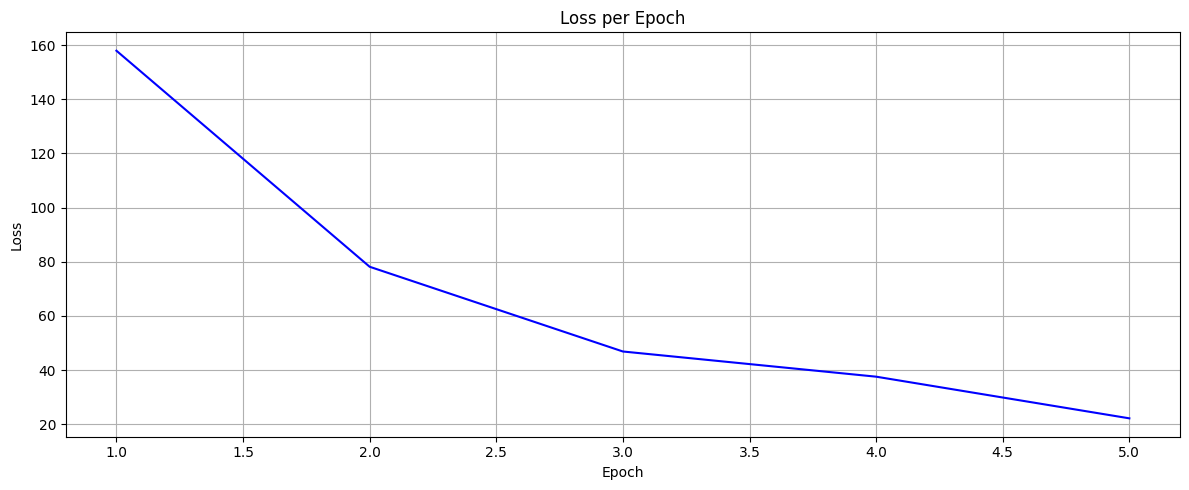

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure size for the plot
plt.figure(figsize=(12, 5))

# Plot the loss values over epochs
plt.plot(range(1, num_epochs + 1), losses, label='Loss', color='blue')

# Label the x-axis and y-axis
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Set the title of the plot
plt.title('Loss per Epoch')

# Enable grid lines for better readability
plt.grid(True)

# Adjust the layout for proper display
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_predictions = []

# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
model.eval()

# Disable gradient calculation during evaluation to save memory
with torch.no_grad():
    # Iterate over the training data in batches
    for images, labels in tqdm(train_loader):  # Progress bar using tqdm
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Perform a forward pass through the model to get the predictions
        outputs = model(images)

        # Get the predicted class (index of the highest output probability)
        _, predicted = torch.max(outputs, 1)

        # Add the true labels and predicted labels to the respective lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_predictions)

# Print the classification report
print("Classification Report for Train Data:")
print(report)


 16%|█▌        | 12/75 [00:05<00:24,  2.59it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 65%|██████▌   | 49/75 [00:19<00:11,  2.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:29<00:00,  2.55it/s]

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        84
           1       0.88      0.84      0.86        83
           2       0.70      0.88      0.78        83
           3       0.93      0.68      0.78        75
           4       0.86      0.92      0.89        78
           5       0.97      0.81      0.88        80
           6       1.00      0.61      0.75        71
           7       0.88      0.68      0.77        76
           8       1.00      0.71      0.83        80
           9       0.93      0.96      0.95        85
          10       0.71      0.98      0.82        81
          11       0.93      0.84      0.88        85
          12       0.69      0.93      0.79        80
          13       0.68      0.98      0.80        82
          14       0.88      0.79      0.84        77

    accuracy                           0.84      1200
   macro avg       0.87      0.84      0.8

In [ ]:
# Initialize empty lists to store all true labels and predicted labels
all_labels = []
all_predictions = []

# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
model.eval()

# No need to compute gradients during evaluation, so we wrap the code in 'torch.no_grad()' to save memory
with torch.no_grad():
    # Iterate over the test data in batches
    for images, labels in tqdm(test_loader):  # 'tqdm' adds a progress bar
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Perform a forward pass through the model to get the predictions
        outputs = model(images)

        # Get the predicted class (index of the highest output probability)
        _, predicted = torch.max(outputs, 1)

        # Add the true labels and predicted labels to the respective lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate a classification report based on all labels and predictions
report = classification_report(all_labels, all_predictions)

# Print the classification report
print("Classification Report:")  # classification report for test data
print(report)


 16%|█▌        | 3/19 [00:01<00:06,  2.62it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 58%|█████▊    | 11/19 [00:03<00:02,  2.80it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:05<00:00,  3.42it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58        16
           1       0.46      0.35      0.40        17
           2       0.35      0.53      0.42        17
           3       0.48      0.40      0.43        25
           4       0.17      0.18      0.17        22
           5       0.46      0.30      0.36        20
           6       0.91      0.34      0.50        29
           7       0.33      0.25      0.29        24
           8       0.33      0.05      0.09        20
           9       0.56      0.60      0.58        15
          10       0.37      0.58      0.45        19
          11       0.40      0.40      0.40        15
          12       0.18      0.35      0.24        20
          13       0.19      0.50      0.28        18
          14       0.60      0.26      0.36        23

    accuracy                           0.36       300
   macro avg       0.43      0.38      0.37       300
wei

## Train model using CNN from scratch

In [ ]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define layers: Conv -> ReLU -> Pool
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 15)

    def forward(self, x):
        # Pass input through conv, relu, and pool layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        # Flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc2(self.fc1(x))
        return x

# Initialize the model and move to the device (GPU/CPU)
model = CustomCNN().to(device)


## Trainging with Stochastic gradient descent optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# Initialize loss storage and number of epochs
losses = []
num_epochs = 5
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Loop through batches in the training data
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        running_loss += loss.item()  # Accumulate the loss

    epoch_loss = running_loss / len(train_loader)  # Average loss for the epoch
    losses.append(epoch_loss)  # Store the loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

 40%|████      | 30/75 [00:18<00:36,  1.25it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 69%|██████▉   | 52/75 [00:31<00:16,  1.37it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


Epoch [1/5], Loss: 2.7074


  4%|▍         | 3/75 [00:01<00:29,  2.40it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 29%|██▉       | 22/75 [00:11<00:36,  1.47it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:38<00:00,  1.93it/s]


Epoch [2/5], Loss: 2.7033


 33%|███▎      | 25/75 [00:11<00:17,  2.94it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 81%|████████▏ | 61/75 [00:27<00:06,  2.26it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


Epoch [3/5], Loss: 2.6992


 25%|██▌       | 19/75 [00:08<00:22,  2.51it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 63%|██████▎   | 47/75 [00:20<00:15,  1.85it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


Epoch [4/5], Loss: 2.6947


 12%|█▏        | 9/75 [00:06<00:40,  1.64it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 52%|█████▏    | 39/75 [00:21<00:26,  1.37it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.15it/s]

Epoch [5/5], Loss: 2.6897


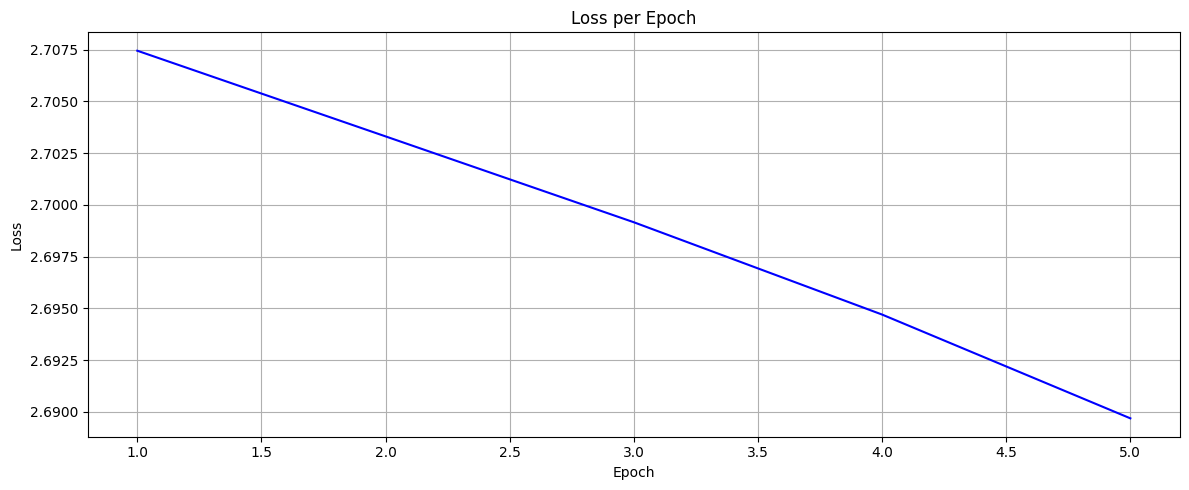

In [ ]:
# Set up the figure size for the plot
plt.figure(figsize=(12, 5))

# Plot the loss values against epochs
plt.plot(range(1, num_epochs + 1), losses, label='Loss', color='blue')

# Add labels for x and y axes
plt.xlabel('Epoch')  # Label for the x-axis (Epochs)
plt.ylabel('Loss')   # Label for the y-axis (Loss)

# Add a title to the plot
plt.title('Loss per Epoch')  # Title for the plot

# Add a grid to the y-axis for better readability
plt.grid(True)

# Automatically adjust the layout to make sure the plot elements fit well
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Initialize empty lists to store all labels and predictions
all_labels = []
all_predictions = []

# Set the model to evaluation mode
model.eval()

# No need to compute gradients during evaluation
with torch.no_grad():
    # Loop through the training data loader
    for images, labels in tqdm(train_loader):
        # Move images and labels to the appropriate device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Get the model's predictions
        outputs = model(images)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Extend the lists with actual labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate a classification report comparing the true labels and the predicted labels
report = classification_report(all_labels, all_predictions)

# Print the classification report for training data
print("Classification Report:")  # This is for training data
print(report)


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 73%|███████▎  | 55/75 [00:22<00:06,  2.99it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:30<00:00,  2.48it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.06      0.10        84
           1       0.67      0.02      0.05        83
           2       0.09      0.76      0.16        83
           3       0.00      0.00      0.00        75
           4       0.15      0.36      0.21        78
           5       0.41      0.11      0.18        80
           6       0.00      0.00      0.00        71
           7       0.00      0.00      0.00        76
           8       0.00      0.00      0.00        80
           9       0.36      0.28      0.32        85
          10       0.00      0.00      0.00        81
          11       0.57      0.05      0.09        85
          12       0.13      0.29      0.18        80
          13       0.21      0.04      0.06        82
          14       0.00      0.00      0.00        77

    accuracy                           0.13      1200
   macro avg       0.20      0.13      0.09      1200
wei


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Initialize empty lists to store all true labels and predictions
all_labels = []
all_predictions = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation for inference (saves memory and computation)
with torch.no_grad():
    # Loop through the test data loader
    for images, labels in tqdm(test_loader):
        # Move images and labels to the appropriate device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Get the model's predictions
        outputs = model(images)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Collect the true labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report comparing true labels and predicted labels
report = classification_report(all_labels, all_predictions)

# Print the classification report for test data
print("Classification Report:")  # This is for the test data
print(report)

  5%|▌         | 1/19 [00:01<00:20,  1.12s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 68%|██████▊   | 13/19 [00:06<00:02,  2.49it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:07<00:00,  2.60it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        17
           2       0.05      0.53      0.10        17
           3       0.00      0.00      0.00        25
           4       0.15      0.32      0.21        22
           5       0.27      0.15      0.19        20
           6       0.00      0.00      0.00        29
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        20
           9       0.28      0.33      0.30        15
          10       0.00      0.00      0.00        19
          11       0.00      0.00      0.00        15
          12       0.14      0.35      0.20        20
          13       0.50      0.11      0.18        18
          14       0.00      0.00      0.00        23

    accuracy                           0.11       300
   macro avg       0.09      0.12      0.08       300
wei


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Trainging with Adam optimizer

In [ ]:
# Loss function for classification (CrossEntropyLoss combines softmax and negative log-likelihood loss)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam optimizer with learning rate 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Initialize loss storage and number of epochs
losses = []
num_epochs = 5
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Loop through batches in the training data
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        running_loss += loss.item()  # Accumulate the loss

    epoch_loss = running_loss / len(train_loader)  # Average loss for the epoch
    losses.append(epoch_loss)  # Store the loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


  1%|▏         | 1/75 [00:01<01:27,  1.18s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 65%|██████▌   | 49/75 [00:33<00:10,  2.59it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


Epoch [1/5], Loss: 2.6438


  7%|▋         | 5/75 [00:02<00:27,  2.58it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


Epoch [2/5], Loss: 2.0595


 47%|████▋     | 35/75 [00:13<00:21,  1.90it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 87%|████████▋ | 65/75 [00:26<00:06,  1.44it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:31<00:00,  2.35it/s]


Epoch [3/5], Loss: 1.8069


  9%|▉         | 7/75 [00:03<00:28,  2.35it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:31<00:00,  2.37it/s]


Epoch [4/5], Loss: 1.4139


  7%|▋         | 5/75 [00:02<00:25,  2.74it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 15%|█▍        | 11/75 [00:04<00:24,  2.62it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:30<00:00,  2.46it/s]

Epoch [5/5], Loss: 1.0459


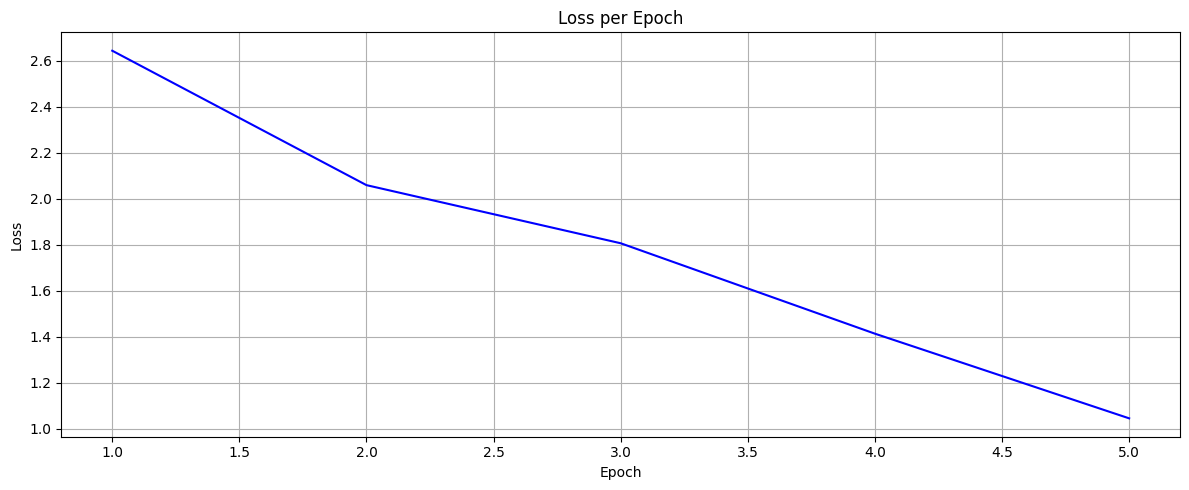

In [ ]:
# Set up the figure size for the plot
plt.figure(figsize=(12, 5))

# Plot the loss values against epochs
plt.plot(range(1, num_epochs + 1), losses, label='Loss', color='blue')

# Add labels for x and y axes
plt.xlabel('Epoch')  # Label for the x-axis (Epochs)
plt.ylabel('Loss')   # Label for the y-axis (Loss)

# Add a title to the plot
plt.title('Loss per Epoch')  # Title for the plot

# Add a grid to the y-axis for better readability
plt.grid(True)

# Automatically adjust the layout to make sure the plot elements fit well
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Initialize empty lists to store all labels and predictions
all_labels = []
all_predictions = []

# Set the model to evaluation mode
model.eval()

# No need to compute gradients during evaluation
with torch.no_grad():
    # Loop through the training data loader
    for images, labels in tqdm(train_loader):
        # Move images and labels to the appropriate device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Get the model's predictions
        outputs = model(images)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Extend the lists with actual labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate a classification report comparing the true labels and the predicted labels
report = classification_report(all_labels, all_predictions)

# Print the classification report for training data
print("Classification Report:")  # This is for training data
print(report)


 13%|█▎        | 10/75 [00:03<00:23,  2.74it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 37%|███▋      | 28/75 [00:08<00:16,  2.82it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:30<00:00,  2.48it/s]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        84
           1       0.93      0.61      0.74        83
           2       0.87      0.87      0.87        83
           3       0.77      0.91      0.83        75
           4       0.86      0.82      0.84        78
           5       0.60      0.94      0.74        80
           6       0.68      0.92      0.78        71
           7       0.86      0.55      0.67        76
           8       0.84      0.94      0.89        80
           9       0.92      0.91      0.91        85
          10       0.91      0.89      0.90        81
          11       0.72      0.93      0.81        85
          12       0.76      0.69      0.72        80
          13       0.87      0.67      0.76        82
          14       0.85      0.78      0.81        77

    accuracy                           0.81      1200
   macro avg       0.83      0.81      0.81      1200
wei

In [ ]:
# Initialize empty lists to store all true labels and predictions
all_labels = []
all_predictions = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation for inference (saves memory and computation)
with torch.no_grad():
    # Loop through the test data loader
    for images, labels in tqdm(test_loader):
        # Move images and labels to the appropriate device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Get the model's predictions
        outputs = model(images)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Collect the true labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report comparing true labels and predicted labels
report = classification_report(all_labels, all_predictions)

# Print the classification report for test data
print("Classification Report:")  # This is for the test data
print(report)


  5%|▌         | 1/19 [00:00<00:10,  1.77it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:05<00:00,  3.44it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.50      0.59        16
           1       0.50      0.24      0.32        17
           2       0.37      0.59      0.45        17
           3       0.53      0.76      0.62        25
           4       0.23      0.14      0.17        22
           5       0.31      0.55      0.40        20
           6       0.43      0.52      0.47        29
           7       0.60      0.25      0.35        24
           8       0.63      0.60      0.62        20
           9       0.71      0.80      0.75        15
          10       0.53      0.53      0.53        19
          11       0.20      0.40      0.27        15
          12       0.44      0.35      0.39        20
          13       0.67      0.22      0.33        18
          14       0.22      0.17      0.20        23

    accuracy                           0.44       300
   macro avg       0.47      0.44      0.43       300
wei

## Train model using EfficientNet

In [ ]:
# Load pre-trained EfficientNet-B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Get the number of input features to the final fully connected layer
num_features = model._fc.in_features

# Replace the final fully connected layer with a new one that has 15 output units
model._fc = nn.Linear(num_features, 15)

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Print the model's architecture
print(model)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 108MB/s] 


Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

## Trainging with Stochastic gradient descent optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
losses = []

# Set number of epochs
num_epochs = 20

# Loop through epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Initialize loss accumulator

    # Iterate over training batches
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()  # Zero gradients
        outputs = model(images)  # Get predictions
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate batch loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    epoch_loss = running_loss / len(train_loader)  # Average epoch loss
    losses.append(epoch_loss)  # Store epoch loss

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

 19%|█▊        | 14/75 [00:16<00:52,  1.17it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 32%|███▏      | 24/75 [00:26<00:37,  1.37it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [01:01<00:00,  1.23it/s]


Epoch [1/20], Loss: 2.7083


 36%|███▌      | 27/75 [00:14<00:17,  2.78it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 45%|████▌     | 34/75 [00:18<00:18,  2.24it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.16it/s]


Epoch [2/20], Loss: 2.6779


 25%|██▌       | 19/75 [00:09<00:19,  2.92it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 33%|███▎      | 25/75 [00:12<00:16,  3.00it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.25it/s]


Epoch [3/20], Loss: 2.6533


  3%|▎         | 2/75 [00:01<00:45,  1.59it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  5%|▌         | 4/75 [00:02<00:43,  1.62it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.19it/s]


Epoch [4/20], Loss: 2.6201


  3%|▎         | 2/75 [00:00<00:30,  2.36it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  8%|▊         | 6/75 [00:02<00:37,  1.83it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Epoch [5/20], Loss: 2.5976


  7%|▋         | 5/75 [00:02<00:25,  2.77it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 44%|████▍     | 33/75 [00:16<00:22,  1.88it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Epoch [6/20], Loss: 2.5704


  8%|▊         | 6/75 [00:01<00:18,  3.75it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 29%|██▉       | 22/75 [00:12<00:26,  2.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:35<00:00,  2.11it/s]


Epoch [7/20], Loss: 2.5415


  7%|▋         | 5/75 [00:02<00:27,  2.56it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 79%|███████▊  | 59/75 [00:28<00:06,  2.47it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.19it/s]


Epoch [8/20], Loss: 2.5112


 40%|████      | 30/75 [00:14<00:15,  2.91it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 93%|█████████▎| 70/75 [00:32<00:02,  2.32it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.15it/s]


Epoch [9/20], Loss: 2.4822


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 23%|██▎       | 17/75 [00:05<00:19,  2.99it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.24it/s]


Epoch [10/20], Loss: 2.4643


 63%|██████▎   | 47/75 [00:20<00:09,  2.93it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 81%|████████▏ | 61/75 [00:26<00:05,  2.55it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.25it/s]


Epoch [11/20], Loss: 2.4270


 16%|█▌        | 12/75 [00:05<00:24,  2.59it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 44%|████▍     | 33/75 [00:14<00:16,  2.51it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:32<00:00,  2.30it/s]


Epoch [12/20], Loss: 2.3978


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 24%|██▍       | 18/75 [00:07<00:24,  2.29it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.17it/s]


Epoch [13/20], Loss: 2.3772


 29%|██▉       | 22/75 [00:10<00:19,  2.67it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 53%|█████▎    | 40/75 [00:17<00:12,  2.83it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Epoch [14/20], Loss: 2.3491


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 72%|███████▏  | 54/75 [00:25<00:09,  2.24it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.18it/s]


Epoch [15/20], Loss: 2.3119


 19%|█▊        | 14/75 [00:05<00:24,  2.46it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 77%|███████▋  | 58/75 [00:24<00:06,  2.62it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.25it/s]


Epoch [16/20], Loss: 2.2877


  1%|▏         | 1/75 [00:00<00:43,  1.71it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 75%|███████▍  | 56/75 [00:23<00:06,  2.95it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.25it/s]


Epoch [17/20], Loss: 2.2577


 29%|██▉       | 22/75 [00:09<00:25,  2.07it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:32<00:00,  2.28it/s]


Epoch [18/20], Loss: 2.2271


 48%|████▊     | 36/75 [00:14<00:11,  3.48it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 63%|██████▎   | 47/75 [00:20<00:13,  2.11it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


Epoch [19/20], Loss: 2.1911


 24%|██▍       | 18/75 [00:09<00:31,  1.80it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 36%|███▌      | 27/75 [00:12<00:14,  3.29it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:37<00:00,  2.01it/s]

Epoch [20/20], Loss: 2.1554


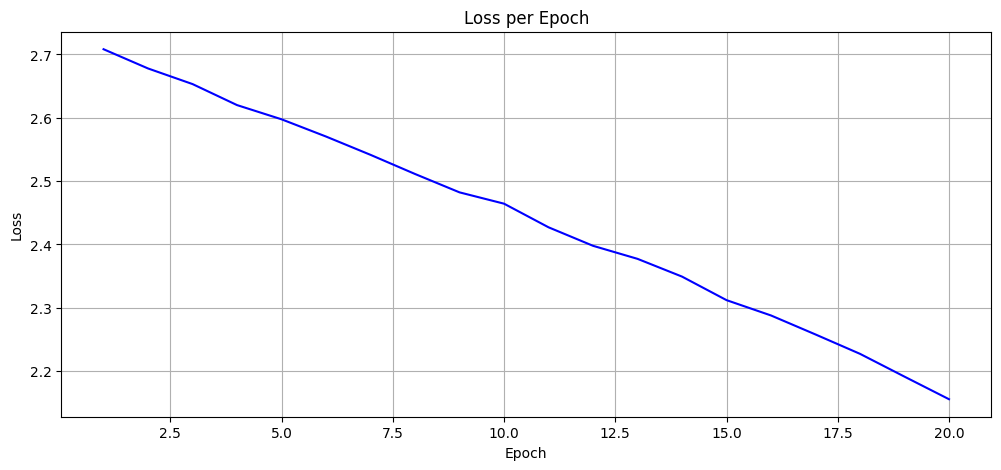

In [ ]:
# Set up the plot figure size
plt.figure(figsize=(12, 5))

# Plot loss values for each epoch
plt.plot(range(1, num_epochs+1), losses, label='Loss', color='blue')

# Label the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Set the plot title
plt.title('Loss per Epoch')

# Show grid lines for clarity
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
# Initialize lists for true labels and predictions
all_labels = []
all_predictions = []

# Set model to evaluation mode
model.eval()

# Disable gradients during inference
with torch.no_grad():
    # Loop through the test data
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(images)

        # Get predicted class (highest probability)
        _, predicted = torch.max(outputs, 1)

        # Store true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(report)

  5%|▌         | 1/19 [00:00<00:13,  1.32it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 37%|███▋      | 7/19 [00:02<00:03,  3.96it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:05<00:00,  3.25it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.62      0.61        16
           1       0.50      0.35      0.41        17
           2       0.50      0.76      0.60        17
           3       0.81      0.84      0.82        25
           4       0.57      0.77      0.65        22
           5       0.77      0.85      0.81        20
           6       0.76      0.76      0.76        29
           7       0.80      0.33      0.47        24
           8       0.83      0.75      0.79        20
           9       0.61      0.93      0.74        15
          10       0.56      0.74      0.64        19
          11       0.60      0.60      0.60        15
          12       0.50      0.15      0.23        20
          13       0.67      0.44      0.53        18
          14       0.59      0.74      0.65        23

    accuracy                           0.65       300
   macro avg       0.64      0.64      0.62       300
wei

In [ ]:
# Initialize lists for true labels and predictions
all_labels = []
all_predictions = []

# Set model to evaluation mode
model.eval()

# Disable gradients during inference
with torch.no_grad():
    # Loop through the test data
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(images)

        # Get predicted class (highest probability)
        _, predicted = torch.max(outputs, 1)

        # Store true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(report)

  0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 47%|████▋     | 9/19 [00:03<00:03,  3.27it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:06<00:00,  2.84it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.62      0.61        16
           1       0.50      0.35      0.41        17
           2       0.50      0.76      0.60        17
           3       0.81      0.84      0.82        25
           4       0.57      0.77      0.65        22
           5       0.77      0.85      0.81        20
           6       0.76      0.76      0.76        29
           7       0.80      0.33      0.47        24
           8       0.83      0.75      0.79        20
           9       0.61      0.93      0.74        15
          10       0.56      0.74      0.64        19
          11       0.60      0.60      0.60        15
          12       0.50      0.15      0.23        20
          13       0.67      0.44      0.53        18
          14       0.59      0.74      0.65        23

    accuracy                           0.65       300
   macro avg       0.64      0.64      0.62       300
wei

## Trainging with Adam optimizer

In [ ]:
# Loss function for multi-class classification (CrossEntropyLoss combines softmax and log-likelihood loss)
criterion = nn.CrossEntropyLoss()

# Optimizer for training the model (Adam with learning rate 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# List to store epoch-wise loss values
losses = []

# Set number of epochs
num_epochs = 20

# Loop through epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Initialize loss accumulator

    # Iterate over training batches
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()  # Zero gradients
        outputs = model(images)  # Get predictions
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate batch loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class

    epoch_loss = running_loss / len(train_loader)  # Average epoch loss
    losses.append(epoch_loss)  # Store epoch loss

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 72%|███████▏  | 54/75 [00:24<00:06,  3.42it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:32<00:00,  2.28it/s]


Epoch [1/20], Loss: 0.9610


 31%|███       | 23/75 [00:11<00:16,  3.17it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 89%|████████▉ | 67/75 [00:30<00:02,  3.00it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Epoch [2/20], Loss: 0.3678


 47%|████▋     | 35/75 [00:16<00:17,  2.23it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.19it/s]


Epoch [3/20], Loss: 0.1515


 27%|██▋       | 20/75 [00:07<00:22,  2.41it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 64%|██████▍   | 48/75 [00:21<00:12,  2.23it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:35<00:00,  2.11it/s]


Epoch [4/20], Loss: 0.1237


 49%|████▉     | 37/75 [00:16<00:11,  3.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 61%|██████▏   | 46/75 [00:19<00:08,  3.38it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.26it/s]


Epoch [5/20], Loss: 0.1394


 40%|████      | 30/75 [00:13<00:14,  3.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 61%|██████▏   | 46/75 [00:20<00:07,  3.65it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Epoch [6/20], Loss: 0.1766


 41%|████▏     | 31/75 [00:14<00:17,  2.52it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 44%|████▍     | 33/75 [00:15<00:22,  1.85it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Epoch [7/20], Loss: 0.1122


 11%|█         | 8/75 [00:05<00:31,  2.10it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 53%|█████▎    | 40/75 [00:20<00:19,  1.75it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


Epoch [8/20], Loss: 0.0825


  4%|▍         | 3/75 [00:02<00:41,  1.73it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 55%|█████▍    | 41/75 [00:18<00:11,  3.09it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.26it/s]


Epoch [9/20], Loss: 0.1003


 16%|█▌        | 12/75 [00:06<00:28,  2.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.27it/s]


Epoch [10/20], Loss: 0.1427


 61%|██████▏   | 46/75 [00:21<00:11,  2.63it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 69%|██████▉   | 52/75 [00:23<00:07,  2.92it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:35<00:00,  2.12it/s]


Epoch [11/20], Loss: 0.1528


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  8%|▊         | 6/75 [00:03<00:23,  2.93it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.23it/s]


Epoch [12/20], Loss: 0.0843


 37%|███▋      | 28/75 [00:14<00:21,  2.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 83%|████████▎ | 62/75 [00:29<00:06,  2.01it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.19it/s]


Epoch [13/20], Loss: 0.0758


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 67%|██████▋   | 50/75 [00:23<00:11,  2.16it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.19it/s]


Epoch [14/20], Loss: 0.0659


 15%|█▍        | 11/75 [00:04<00:25,  2.50it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████      | 30/75 [00:11<00:23,  1.90it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.26it/s]


Epoch [15/20], Loss: 0.0333


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.23it/s]


Epoch [16/20], Loss: 0.0208


  7%|▋         | 5/75 [00:01<00:23,  3.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████      | 30/75 [00:12<00:14,  3.07it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


Epoch [17/20], Loss: 0.0191


 19%|█▊        | 14/75 [00:08<00:45,  1.33it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 64%|██████▍   | 48/75 [00:25<00:14,  1.87it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:35<00:00,  2.13it/s]


Epoch [18/20], Loss: 0.0161


 51%|█████     | 38/75 [00:17<00:15,  2.38it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:34<00:00,  2.17it/s]


Epoch [19/20], Loss: 0.0336


 28%|██▊       | 21/75 [00:08<00:14,  3.71it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 67%|██████▋   | 50/75 [00:20<00:07,  3.17it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.25it/s]

Epoch [20/20], Loss: 0.0334


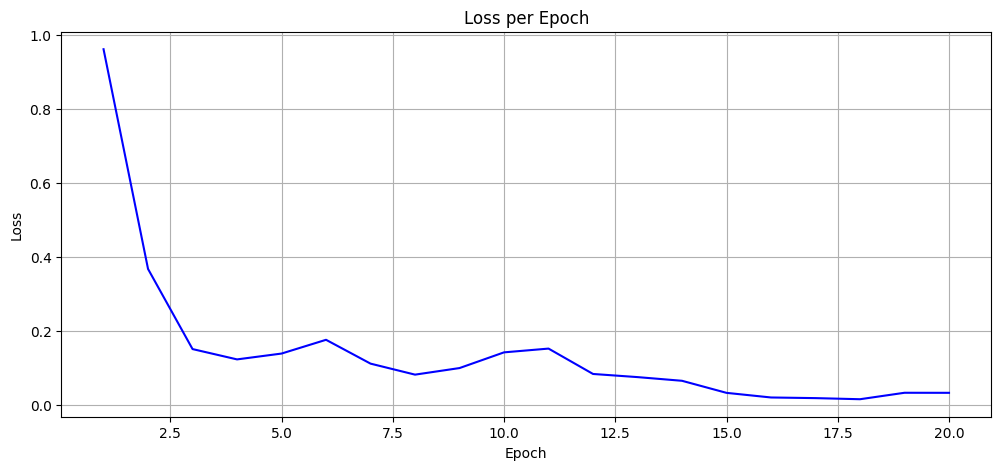

In [ ]:
# Set up the plot figure size
plt.figure(figsize=(12, 5))

# Plot loss values for each epoch
plt.plot(range(1, num_epochs+1), losses, label='Loss', color='blue')

# Label the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Set the plot title
plt.title('Loss per Epoch')

# Show grid lines for clarity
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

# Set the model to evaluation mode (disables dropout, batch norm, etc.)
model.eval()

# Disable gradient calculations for inference
with torch.no_grad():
    # Loop through the training data loader
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Perform a forward pass through the model
        outputs = model(images)

        # Get predicted class by selecting the class with the highest probability
        _, predicted = torch.max(outputs, 1)

        # Store true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(report)


 40%|████      | 30/75 [00:14<00:20,  2.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 87%|████████▋ | 65/75 [00:29<00:03,  3.01it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 75/75 [00:33<00:00,  2.26it/s]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      0.99      0.99        83
           2       1.00      1.00      1.00        83
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        78
           5       1.00      1.00      1.00        80
           6       0.97      1.00      0.99        71
           7       1.00      0.99      0.99        76
           8       1.00      1.00      1.00        80
           9       1.00      1.00      1.00        85
          10       1.00      1.00      1.00        81
          11       1.00      1.00      1.00        85
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        82
          14       1.00      1.00      1.00        77

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
wei

In [ ]:
# Initialize lists for true labels and predictions
all_labels = []
all_predictions = []

# Set model to evaluation mode
model.eval()

# Disable gradients during inference
with torch.no_grad():
    # Loop through the test data
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(images)

        # Get predicted class (highest probability)
        _, predicted = torch.max(outputs, 1)

        # Store true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(report)


 37%|███▋      | 7/19 [00:02<00:03,  3.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:05<00:00,  3.36it/s]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.93      0.82      0.88        17
           2       0.94      0.94      0.94        17
           3       1.00      0.84      0.91        25
           4       0.78      0.95      0.86        22
           5       0.95      0.90      0.92        20
           6       0.96      0.93      0.95        29
           7       0.83      1.00      0.91        24
           8       0.94      0.85      0.89        20
           9       1.00      1.00      1.00        15
          10       1.00      0.84      0.91        19
          11       0.92      0.73      0.81        15
          12       0.65      0.75      0.70        20
          13       0.82      1.00      0.90        18
          14       0.91      0.87      0.89        23

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
wei

## Predict image and visualize image on test data

In [ ]:
def predict_image(img, model):
    # Add batch dimension and move image to the device
    xb = img.unsqueeze(0).to(device)

    # Get model's raw output (logits)
    yb = model(xb)

    # Get the predicted class (index with max value)
    _, preds = torch.max(yb, dim=1)

    # Return the predicted class label
    return dataset.classes[preds[0].item()]


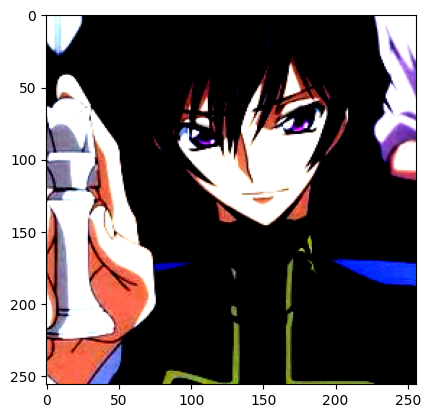

Label: Lelouch Lamperouge , Predicted: Lelouch Lamperouge


In [ ]:
img, label = test_dataset[1]  # Get the 5th image and its label

# Display the image
plt.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
plt.show()

# Print actual and predicted labels
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# The best option is pre-trained EfficientNet, according to accuracy on train and test data